In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import copy
import tsplib95 as tlib

from networkx.algorithms import community

warnings.simplefilter('ignore')

In [2]:
"""
    Metoda care citeste un graf dintr-un fisier de tip tsp
    @params: filename - path catre un fisier tsp 
    @return: Graph - un obiect de tip Graph
"""
def readGraph(filename):
   return tlib.load(filename).get_graph()

In [3]:
def readSolution(filename):
    lista = []
    with open(filename) as f:
        for _ in range(5):
            f.readline()

        for line in f:
            value = int(line.split()[0])
            if value == -1:
                break
            lista.append(value)
    
    return lista

In [4]:
"""
    Metoda care afiseaza impartirea in comunitati a algoritmului impreuna cu cea true, daca aceasta este data
    @params: G - reteaua
             predictedCommunities - impartirea in comunitati prezisa
             targetCommunities - adevarata impartirea in comunitati
             node_size - marimea nodurilor din desen 
"""
def plotPredictedTargetNetworkAndFitness(G, fitness, predictedCommunities, fitnesses, generations, targetCommunities = None, node_size = 50):
    np.random.seed(42)


    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)

    fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

    nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = predictedCommunities, ax = axis[0])
    nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[0]) # alpha = edge transparancy
    nx.draw_networkx_labels(G, pos, ax = axis[0]) # alpha = edge transparancy
    axis[0].set_title("Predicted \n number of communities = " + str(len(np.unique(predictedCommunities))) + "\n fitness = " + str(fitness))

    if targetCommunities != None:
        nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = targetCommunities, ax = axis[1])
        nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[1]) # alpha = edge transparancy
        nx.draw_networkx_labels(G, pos, ax = axis[1]) # alpha = edge transparancy
        axis[1].set_title("target")
    
    axis[2].plot(range(1, generations + 1), fitnesses, '-r')

In [5]:
def plotTSP(G, chromosomes, fitnesses, optim, noGen, node_size = 50):
    np.random.seed(42)

    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    
    for chr, color in zip(chromosomes, list(range(len(chromosomes)))):
        repr = chr.representation[:]
        repr.append(repr[0])
        for x, y in zip(repr, repr[1:]):
            H.add_edge(x, y, color = color)

    pos = nx.spring_layout(H)
    _, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

    nx.draw_networkx_nodes(H, pos, node_size = node_size, cmap = plt.cm.RdYlBu, ax = axis[0])

    edges = H.edges()
    colors = [H[x][y]['color'] for x, y in edges]

    nx.draw_networkx_edges(H, pos, alpha = 0.7, ax = axis[0], edgelist=edges, edge_color=colors)
    nx.draw_networkx_labels(G, pos, ax = axis[0]) # alpha = edge transparancy

    axis[1].set_title("Predicted = " + str(chromosomes[0].fitness) + " \noptim = " + str(optim))
    axis[1].plot(list(range(noGen)), fitnesses, '-r')


In [6]:
"""
    Metoda care returneaza un element ales aleator din lista data
    @params: list - o lista
    @return: un element din lista
"""
def uniformChoiceList(list):
    return np.random.choice(list)

In [7]:
class Chromosome:

    def __init__(self, graph = None, representation = None):
        self.__representation = []
        if graph != None:
            self.__possibleValues = list(graph.nodes())
            self.__representation = np.random.permutation(list(graph.nodes()))
        elif representation != None:
            self.__representation = representation  
            
        self.__fitness = None 

    @property
    def representation(self):
        return self.__representation
    
    @property
    def fitness(self):
        return self.__fitness
    
    @representation.setter
    def representation(self, representation = []):
        self.__representation = representation 
    
    @fitness.setter
    def fitness(self, fitness = None):
        self.__fitness = fitness
    
    def representationEdges(self):
        edges = []

        for i in range(len(self.__representation) - 1):
            edges.append([self.__representation[i] - 1, self.__representation[i + 1] - 1])
        
        edges.append([self.__representation[0] - 1, self.__representation[len(self.__representation) - 1] - 1])

        return edges

    @classmethod
    def __getEdgeDict(cls, chr1, chr2):
        edgeDict = dict([x, set()] for x in chr1.representation)
        edgeDict[chr1.representation[0]].add(chr1.representation[1])
        edgeDict[chr2.representation[0]].add(chr2.representation[1])
        edgeDict[chr1.representation[0]].add(chr1.representation[len(chr1.representation) - 1])
        edgeDict[chr2.representation[0]].add(chr2.representation[len(chr1.representation) - 1])

        edgeDict[chr1.representation[len(chr1.representation) - 1]].add(chr1.representation[0])
        edgeDict[chr2.representation[len(chr1.representation) - 1]].add(chr2.representation[0])
        edgeDict[chr1.representation[len(chr1.representation) - 1]].add(chr1.representation[len(chr1.representation) - 2])
        edgeDict[chr2.representation[len(chr1.representation) - 1]].add(chr2.representation[len(chr1.representation) - 2])

        for i in range(1, len(chr1.representation) - 1):
            edgeDict[chr1.representation[i]].add(chr1.representation[i + 1])
            edgeDict[chr2.representation[i]].add(chr2.representation[i + 1])
            edgeDict[chr1.representation[i]].add(chr1.representation[i - 1])
            edgeDict[chr2.representation[i]].add(chr2.representation[i - 1])

        return edgeDict
        
    @classmethod
    def __removeFromEdgeDictNode(cls, edgeDict, selectedNode):
        del edgeDict[selectedNode]

        return edgeDict
    
    @classmethod
    def __removeFromEdgeDictEdge(cls, edgeDict, selectedNode):
        for node in edgeDict.keys():
            if selectedNode in edgeDict[node]:
                edgeDict[node].discard(selectedNode)
        
        return edgeDict

    @classmethod
    def __getLoneliestNodes(cls, edgeDict, latestNode):
        minim = 0x3f3f3f3f 
        result = []
        for node in edgeDict.keys():
            if latestNode in edgeDict[node]:
                length = len(edgeDict[node])
                if length < minim:
                    result = [node]
                    minim = length
                elif length == minim:
                    result.append(node)

        return result
    
    @classmethod
    def __randomNodeNotInRepresentation(cls, possibleValues, representation):
        notPresent = []
        for i in possibleValues:
            if i not in representation:
                notPresent.append(i)
        
        return np.random.choice(notPresent)


    @classmethod
    def __nearestNeighbor(cls, node, graph):
        minim = 0x3f3f3f3f
        result = list(graph.neighbors(node))[0]

        for ngh in graph.neighbors(node):
            if graph[node][ngh]['weight'] < minim:
                minim = graph[node][ngh]['weight']
                result = ngh
        
        return result

    """
        Metoda care produce o incrucisare intre doi cromozomi
        @params: chr - un cromozom
        @return: un cromozom reprezentand rezultatul incrucisarii celor dou
    """
    def crossover(self, chr): 
        newRepresenation = [np.random.choice([self.__representation[0], chr.representation[0]])]
        edgeDict = Chromosome.__getEdgeDict(self, chr)
        edgeDict = Chromosome.__removeFromEdgeDictNode(edgeDict, newRepresenation[0])

        for _ in range(1, len(self.__representation)):
            loneliestNodes = Chromosome.__getLoneliestNodes(edgeDict, newRepresenation[len(newRepresenation) - 1]) 
            edgeDict = Chromosome.__removeFromEdgeDictEdge(edgeDict, newRepresenation[len(newRepresenation) - 1])

            if len(loneliestNodes) == 0:
                selectedNode = Chromosome.__randomNodeNotInRepresentation(self.__possibleValues, newRepresenation)
            else:
                selectedNode = np.random.choice(loneliestNodes)
            edgeDict = Chromosome.__removeFromEdgeDictNode(edgeDict, selectedNode)
            newRepresenation.append(selectedNode)

        offspring = Chromosome()        
        offspring.representation = newRepresenation
        offspring.__possibleValues = self.__possibleValues
        return offspring
    
    def __inversionMutation(self):
        pos1 = np.random.randint(0, len(self.__representation) - 2)
        pos2 = np.random.randint(pos1 + 1, len(self.__representation))
        middle = list(reversed(self.__representation[(pos1 + 1):(pos2 + 1)]))

        for i in range(pos1 + 1, pos2 + 1):
            self.__representation[i] = middle[i - pos1 - 1]

    """
        Metoda care produce o mutatie la nivelul cromozomului
        @params: network - reteaua pentru care se identifica comunitatile
        @return: -
    """
    def mutation(self, graph):
        self.__inversionMutation()
        #self.__rgibnnm(graph)
    
    def __rgibnnm(self, graph):
        pos = np.random.randint(0, len(self.__representation))
        nearestNeighbor = Chromosome.__nearestNeighbor(self.__representation[pos], graph)
        nghPosition = list(self.__representation).index(nearestNeighbor)

        swapPos = np.random.choice(list(range(max(0, nghPosition - 5), min(len(self.__representation), nghPosition + 6))))
        self.__representation[pos], self.__representation[swapPos] = self.__representation[swapPos], self.__representation[pos]

In [8]:
class PathFitness:

    def __init__(self, graph):
        self.__graph = graph 

    def __call__(self, representation):
        result = 0
        minim = min(representation)
        minimNodes = min(list(self.__graph.nodes()))
        for i in range(len(representation) - 1):
            result += self.__graph[representation[i]][representation[i + 1]]["weight"]
        
        result += self.__graph[representation[0]][representation[len(representation) - 1]]["weight"]
        return result
        

In [9]:
class GA:
    def __init__(self, params, problParams):
        self.__params = params
        self.__problParams = problParams
        self.__population = []

        self.__initialization()
        self.__evaluation()
        self.__bestChrs = [self.__population[0]]
    
    def __initialization(self):
        for _ in range(self.__params['popSize']):
            self.__population.append(Chromosome(graph = self.__problParams['graph']))

    @property
    def population(self):
        return self.__population
    
    def __evaluation(self):
        for chr in self.__population:
            if chr.fitness == None:
                chr.fitness = self.__problParams['fitness'](chr.representation)
        
        self.__probabilities = self.__populationProbabilities(self.__population) 
    
    def bestChromosomes(self):
        bestFitness = 0x3f3f3f3f
        bests = [self.__population[0]]
        for chr in self.__population:
            if chr.fitness < bestFitness:
                bests = [chr]
                bestFitness = chr.fitness
            elif chr.fitness == bestFitness:
                bests.append(chr)
        return bests

    def worstChromosome(self):
        worst = self.__population[0]
        for chr in self.__population:
            if chr.fitness > worst.fitness:
                worst = chr
        return worst 
    
    def __selection(self):
        """
        best = self.__population[np.random.randint(0, self.__params['popSize'])]
        
        for _ in range(self.__params['k'] - 1):
            position = np.random.randint(0, self.__params['popSize'])
            if best.fitness < self.__population[position].fitness:
                best = self.__population[position] 

        return best
        """

        position1 = np.random.randint(0, self.__params['popSize'])
        position2 = np.random.randint(0, self.__params['popSize'])
        if self.__population[position1].fitness < self.__population[position2].fitness:
            return self.__population[position1]
        return self.__population[position2]
        
    def __sampleChromosomes(self, population, number, probabilities):
        return list(np.random.choice(population, size = number, p = probabilities, replace = False))
    
    def __populationProbabilities(self, population):
        fitnessSum = sum([1 / chr.fitness for chr in population])
        return [(1 / chr.fitness) / fitnessSum for chr in population]
    
    def __oneRoulleteFractionGenerator(self):
        newPop = self.__sampleChromosomes(self.__population, int(self.__params['pc'] * self.__params['popSize']), self.__probabilities)
        probabilities = self.__populationProbabilities(newPop) 

        crossoverPop = []
        for _ in range(self.__params['popSize'] - len(newPop)):
            chrs = self.__sampleChromosomes(newPop, 2, probabilities)
            crossoverPop.append(chrs[0].crossover(chrs[1]))
        newPop.extend(crossoverPop)
        
        for i in range(self.__params['popSize']):
            if np.random.random() <= self.__params['pm']:
                newPop[i].mutation(self.__problParams['graph'])
        
        self.__population = newPop
        self.__evaluation()

    def __oneGeneration(self):
        newPop = []
        for _  in range(self.__params['popSize']):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            offspring.mutation(self.__problParams['graph'])
            newPop.append(offspring)

        self.__population = newPop
        self.__evaluation()

    def __oneGenerationElitism(self):
        newPop = self.bestChromosomes()
        for _  in range(self.__params['popSize'] - len(newPop)):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            newPop.append(offspring)

        for i in range(self.__params['popSize']):
            if np.random.random() <= self.__params['pm']:
                newPop[i].mutation(self.__problParams['graph'])

        self.__population = newPop
        self.__evaluation()
    
    def __oneGenerationSteadyState(self):
        for _ in range(self.__params['popSize']):
            chr1 = self.__selection()
            chr2 = self.__selection()
            offspring = chr1.crossover(chr2)
            offspring.mutation(self.__problParams['graph'])
            offspring.fitness = self.__problParams['fitness'](offspring.representation)
            worst = self.worstChromosome()
            if offspring.fitness < worst.fitness:
                worst = offspring

    def solve(self):
        fitnesses = []
        for _ in range(self.__params['noGen']):
            self.__oneGenerationElitism()
            bestChrs = self.bestChromosomes()

            if self.__bestChrs[0].fitness > bestChrs[0].fitness:
                self.__bestChrs = bestChrs[:]
            elif self.__bestChrs[0] == bestChrs[0].fitness:
                self.__bestChrs.extend(bestChrs)

            fitnesses.append(bestChrs[0].fitness)
        
        return [self.__bestChrs, fitnesses]

In [10]:
graphs = [readGraph(os.path.join(os.getcwd(), 'data', 'bays29.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'berlin52.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'ch130.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'ch150.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'eil101.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'gr24.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'gr48.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'pr76.tsp'))]
opts = [readSolution(os.path.join(os.getcwd(), 'data', 'bays29.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'berlin52.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'ch130.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'ch150.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'eil101.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'gr24.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'gr48.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'pr76.opt.tour'))]

In [11]:
gaParams = {'popSize': 256, 'noGen': 2048, 'k': 2, 'pc' : 0.95, 'pm': 0.1}


In [12]:
def solveAndPlot(graph, optim):
    params = {'graph': graph, 'fitness': PathFitness(graph)}
    ga = GA(gaParams, params)
    [chromosomes, fitnesses] = ga.solve()
    
    plotTSP(graph, chromosomes, fitnesses, params['fitness'](optim), gaParams['noGen'])

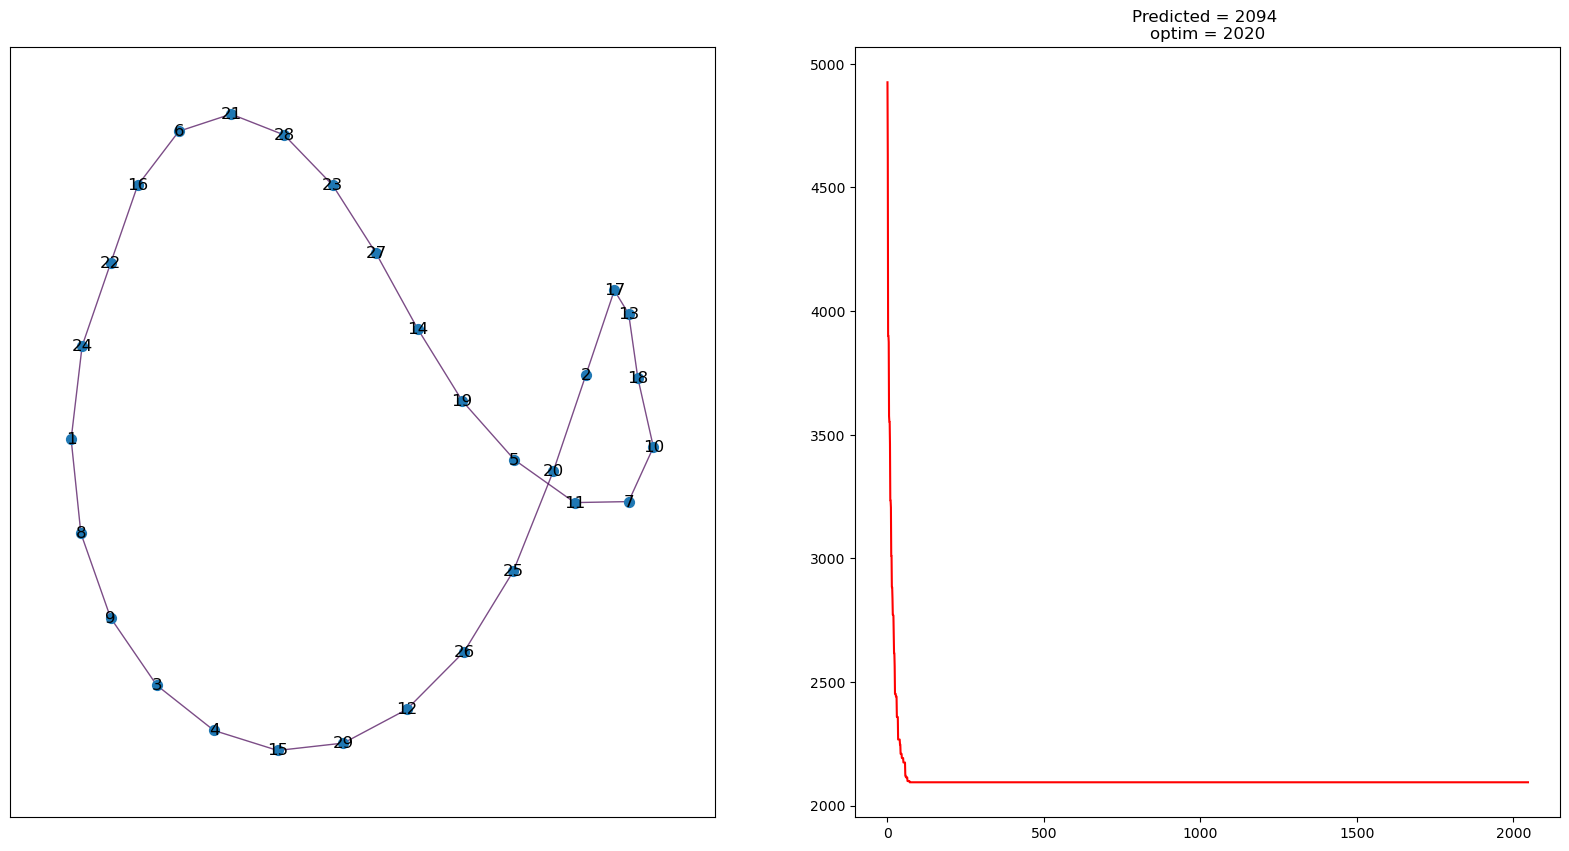

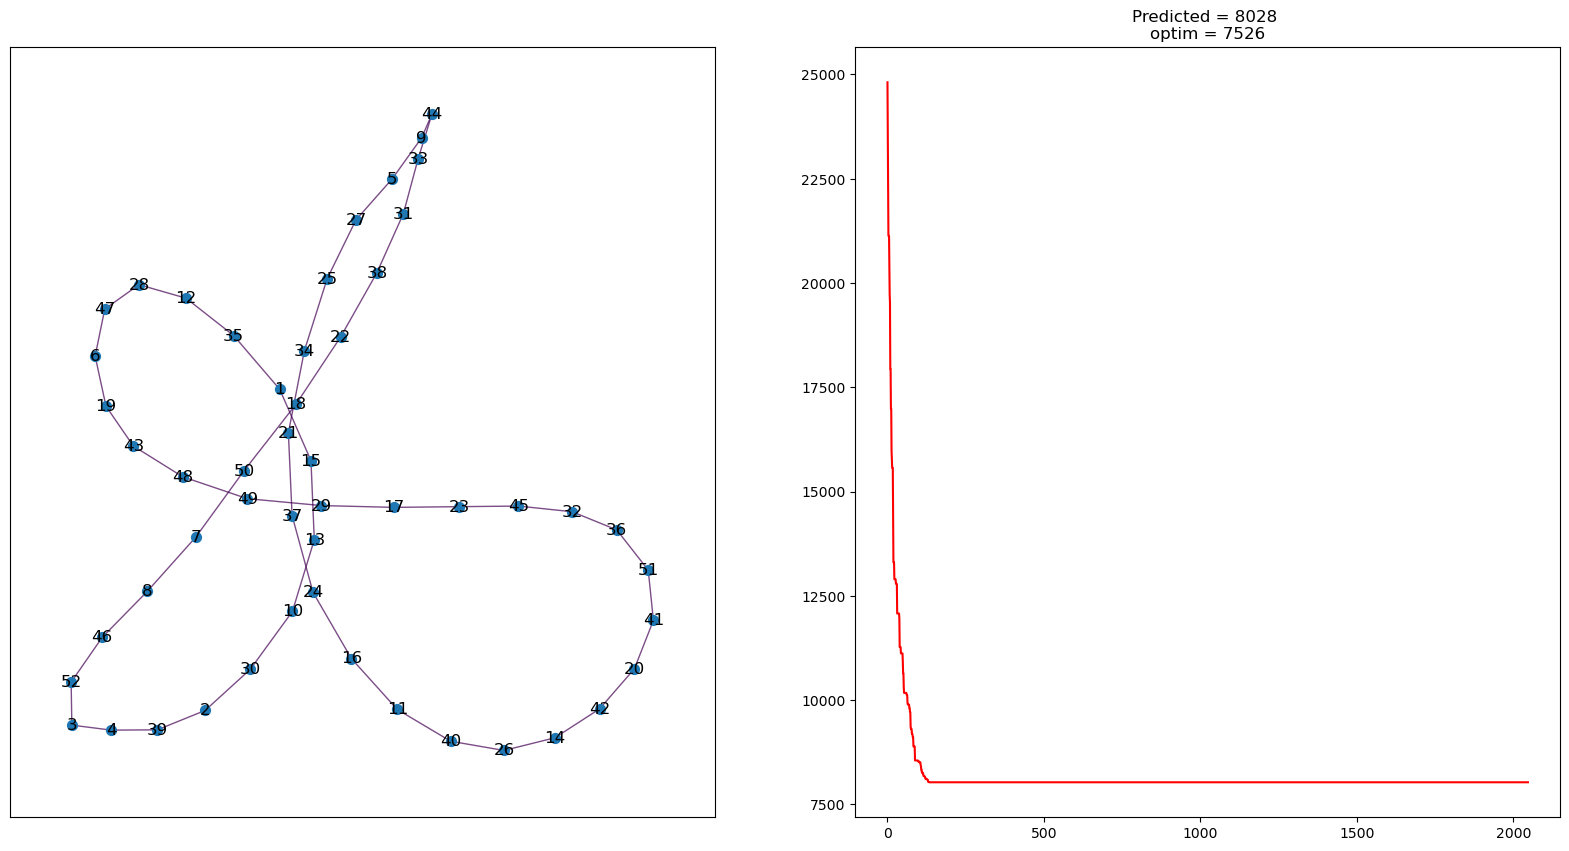

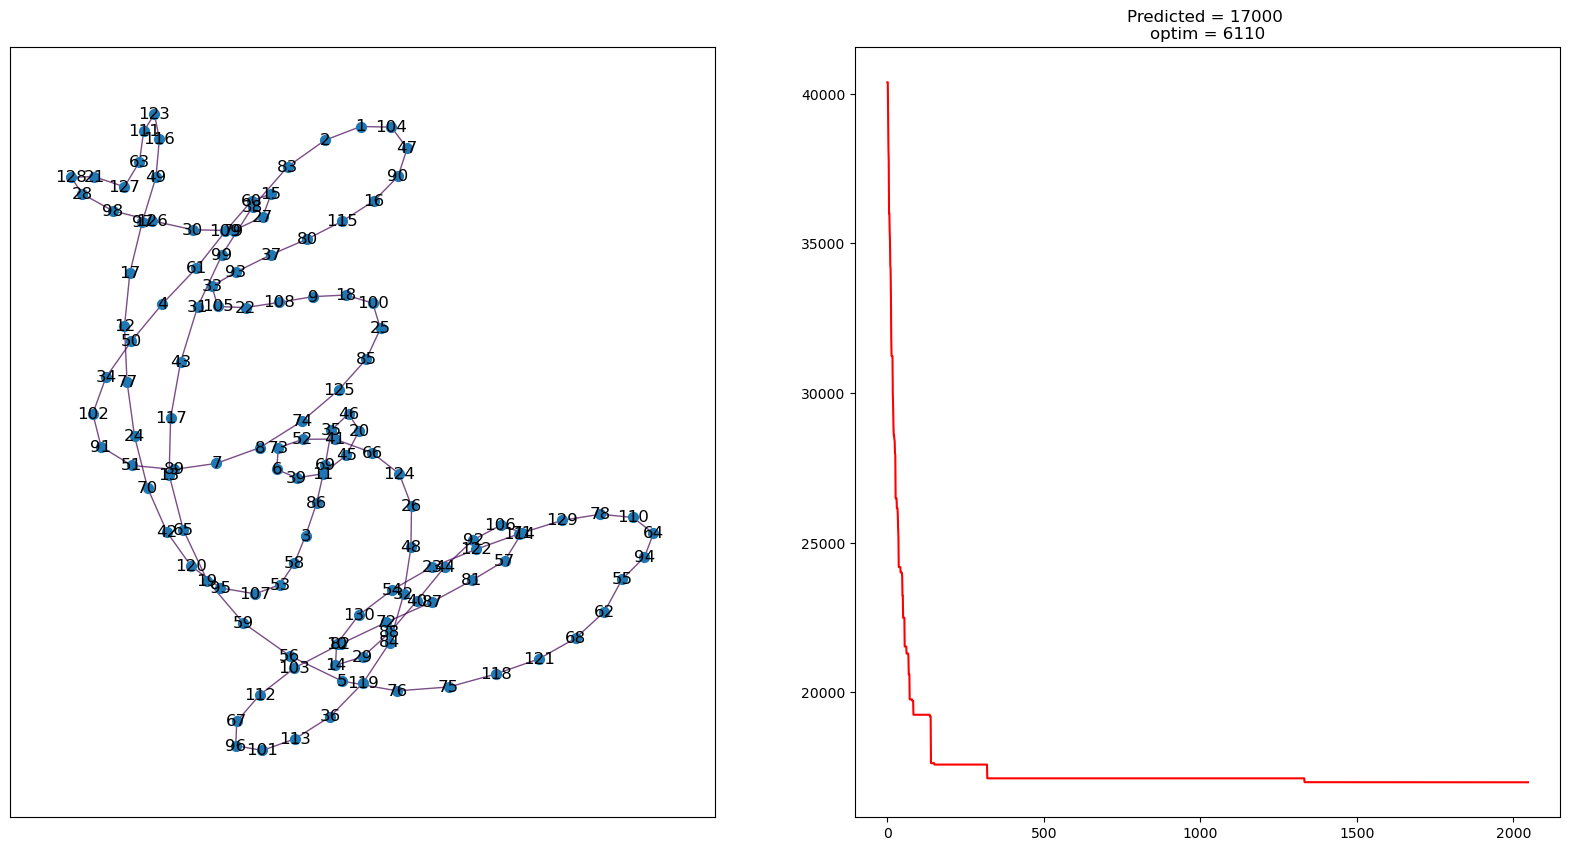

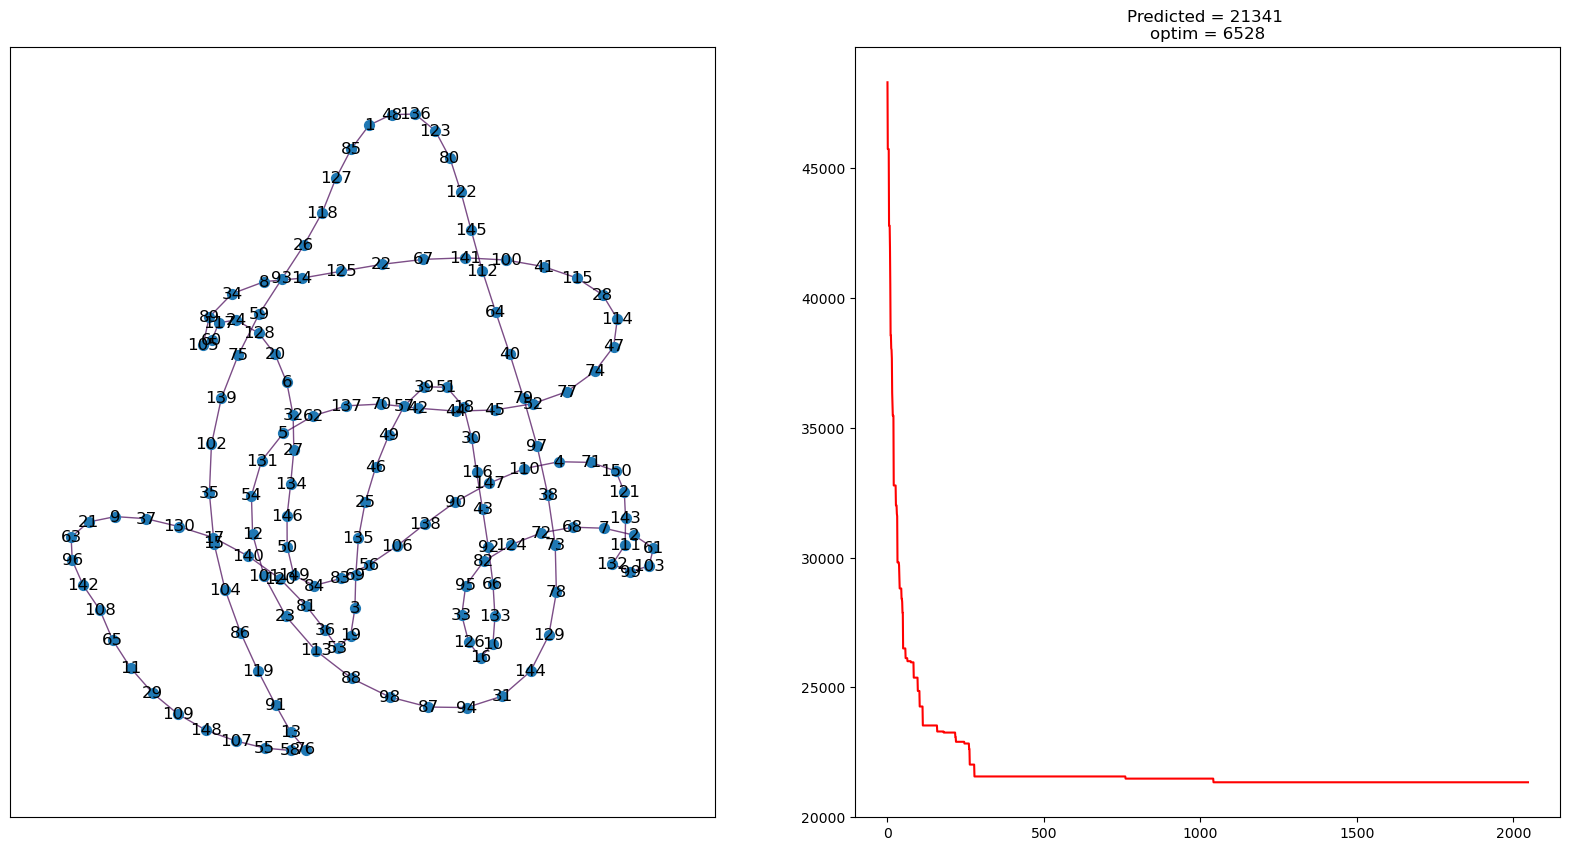

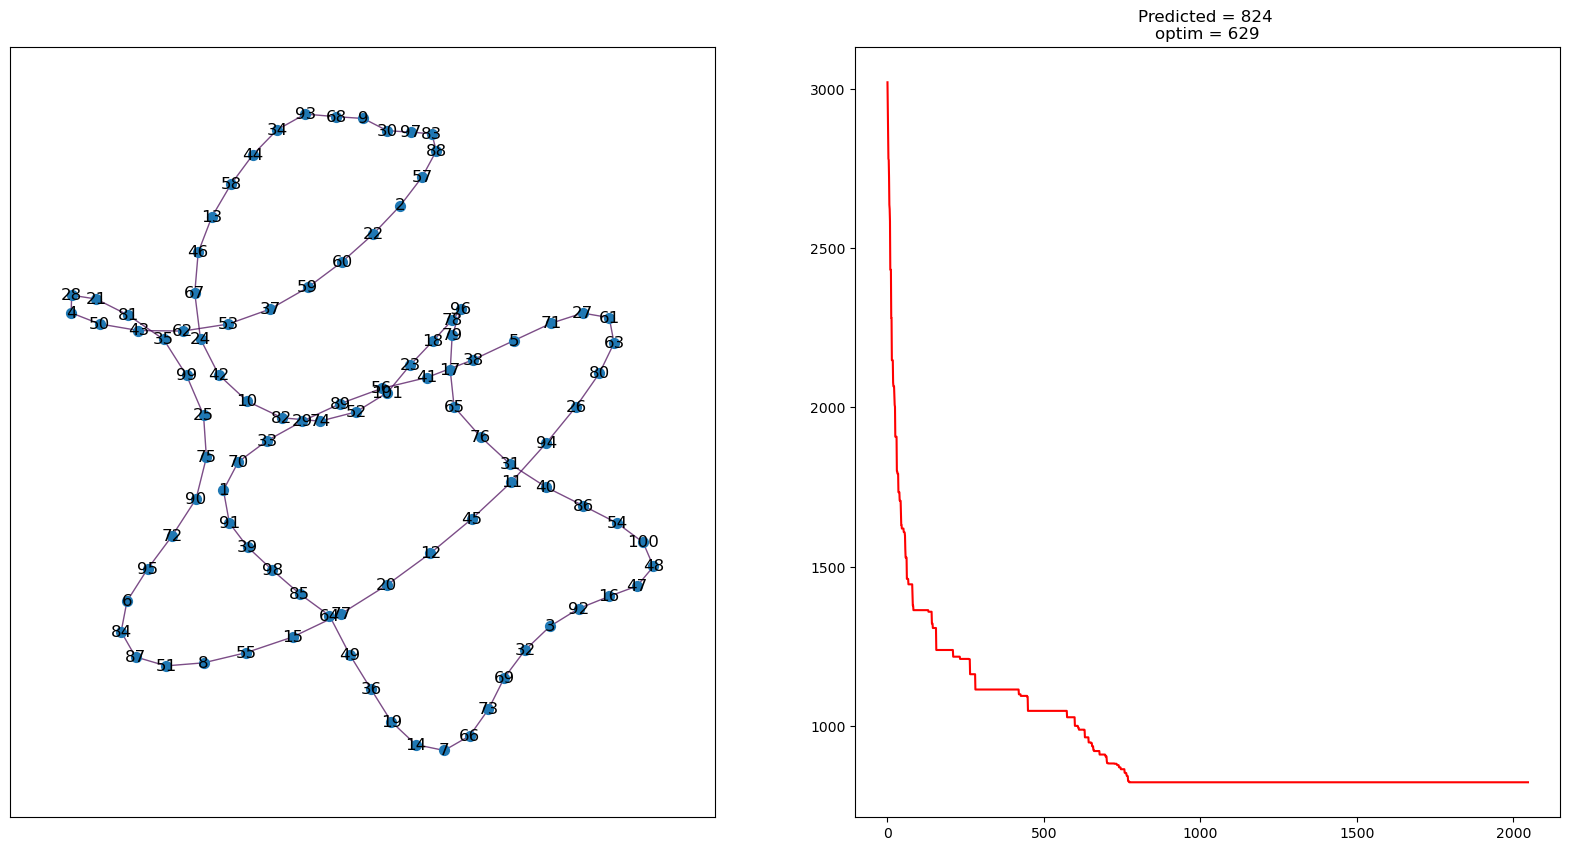

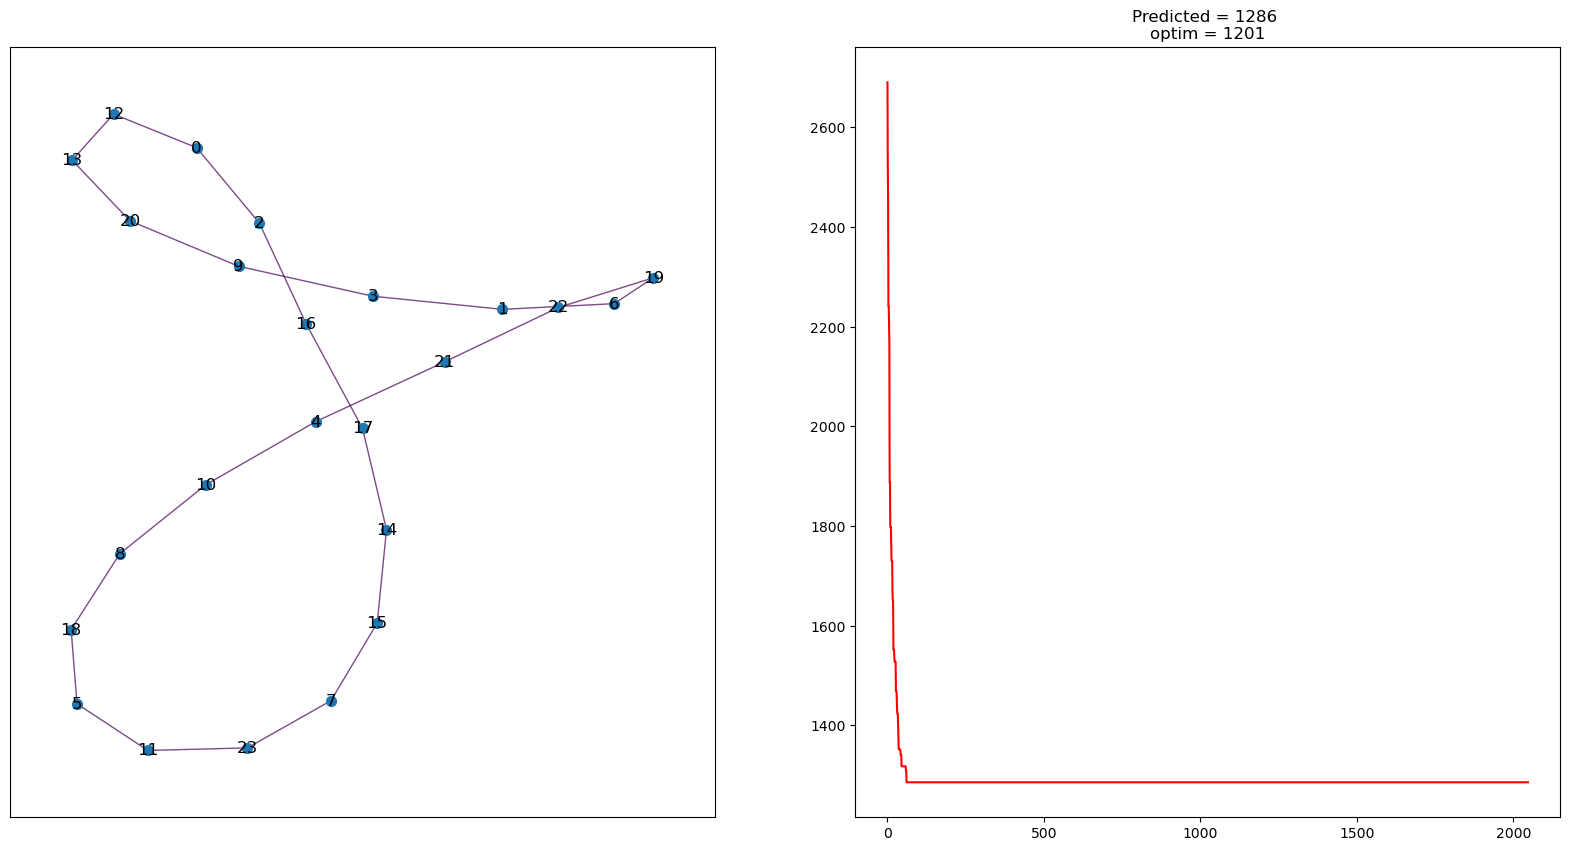

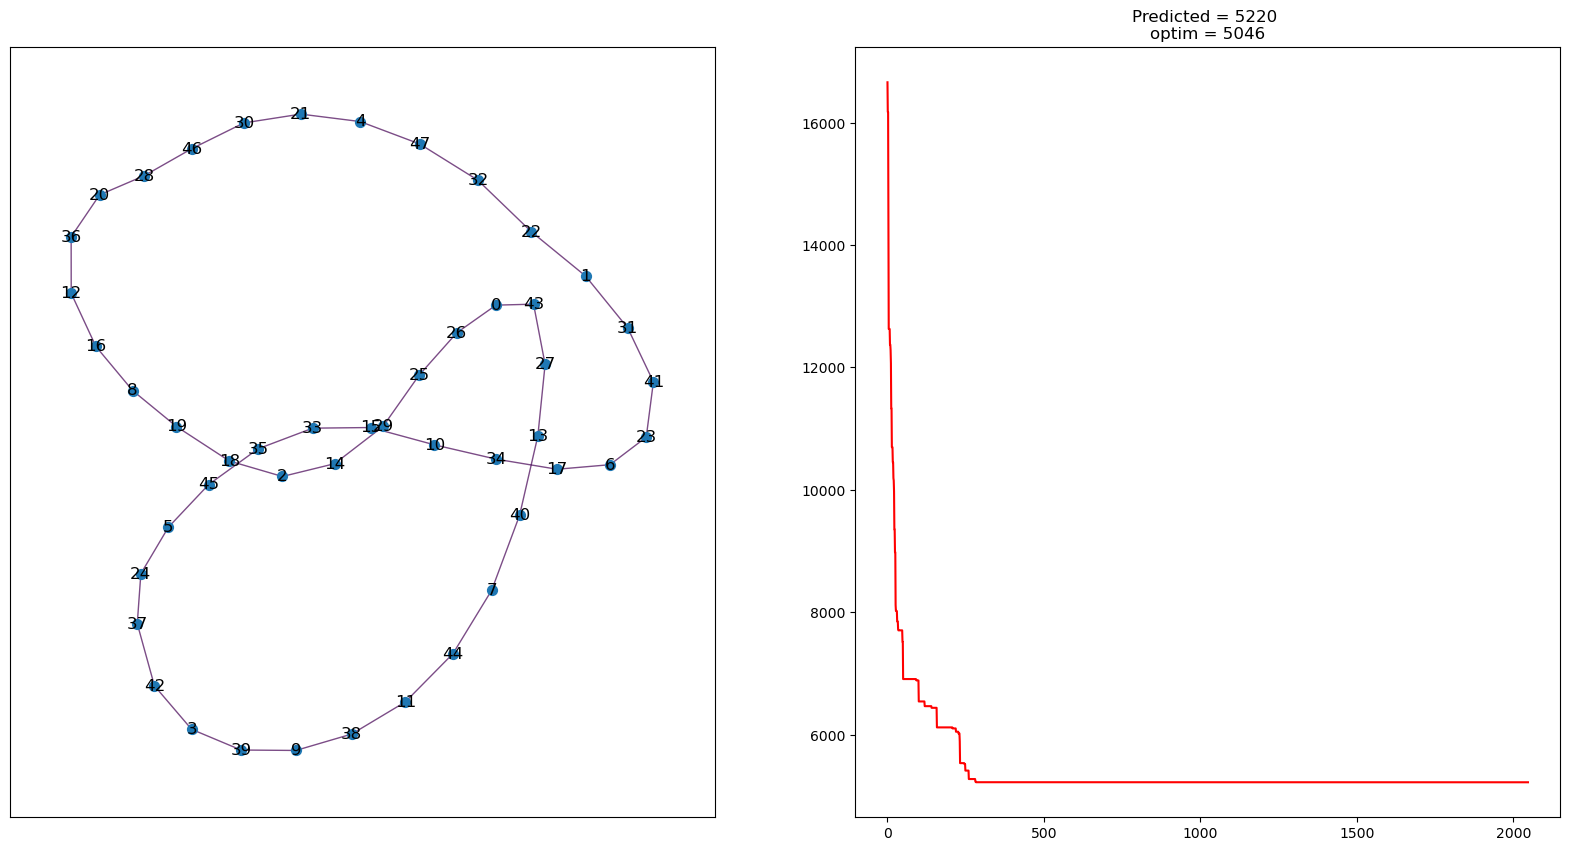

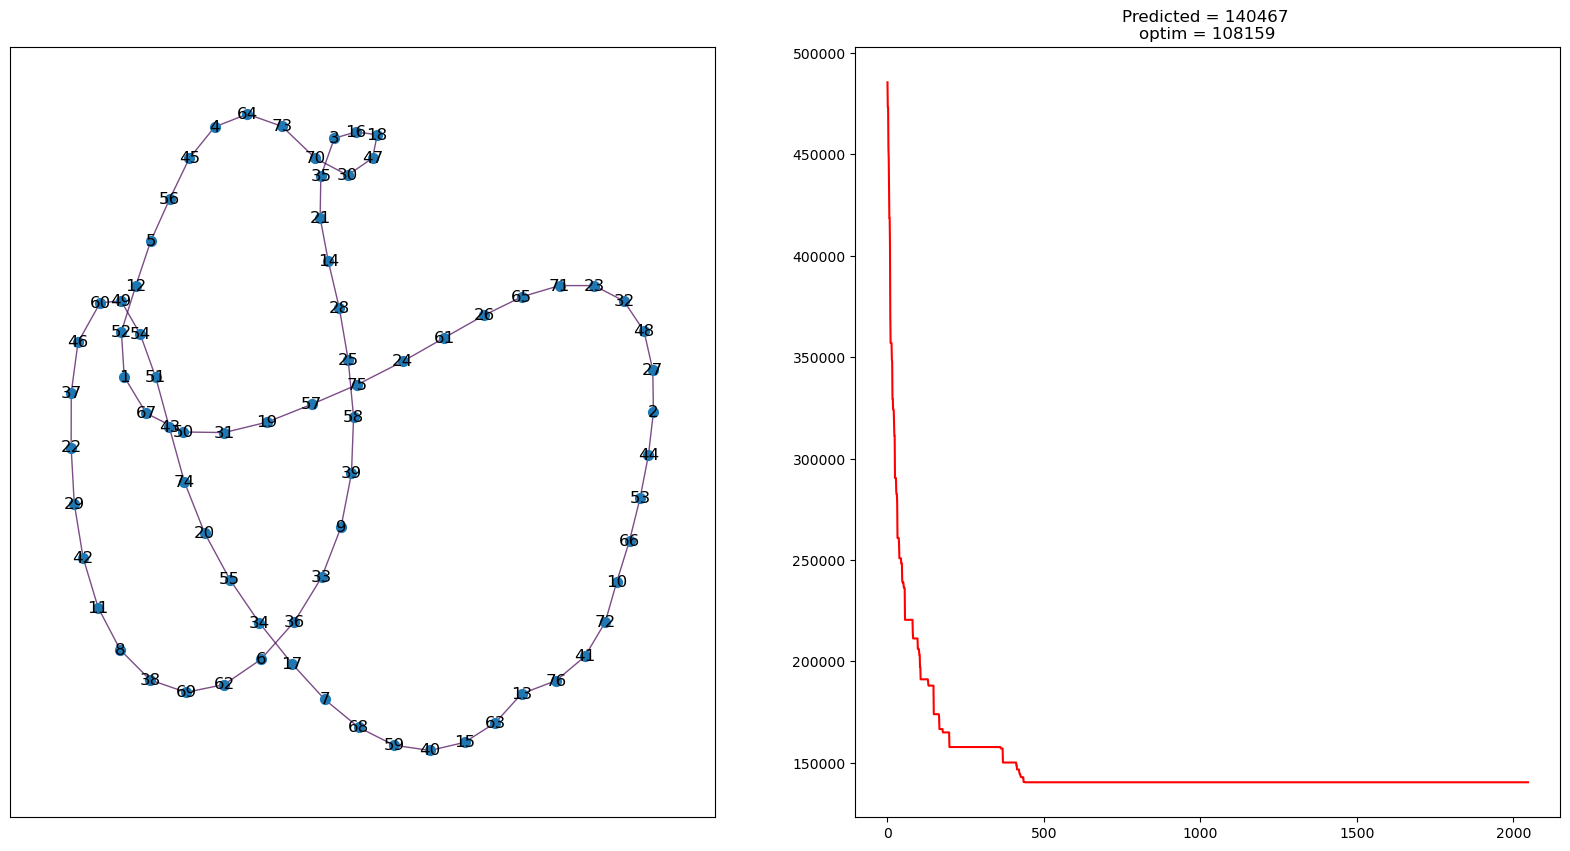

In [13]:
for graph, optim in zip(graphs, opts):
    solveAndPlot(graph, optim)
